In [1]:
import sklearn

In [14]:
from sklearn.isotonic import IsotonicRegression
import pandas as pd
from sklearn.metrics import brier_score_loss
from pathlib import Path
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

def get_calibration_model(path):
    # Get results df
    name = "results_.csv"
    results_df = pd.read_csv(Path("../../evaluation/05_results") / path / name)

    # Extract information about true positives vs false postives and plot calibration curve
    all_true = []
    all_predicted = []
    id_cols = sorted([col for col in results_df.columns if col.startswith("id_")])
    for id_col in id_cols[:-1]:
        id = int(id_col.split("_")[1])
        y_true = results_df[f"id_{id}"] == results_df[f"id_{id+1}"]
        y_prob = results_df[f"p{id}_{id+1}"].to_numpy()
        all_predicted = all_predicted + y_prob.tolist()
        all_true = all_true + y_true.tolist()

    model = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip", increasing="auto")
    model.fit(all_predicted, all_true)

    return model


In [15]:
def plot_calibration(path, calibration_model):
    # Prepare fig
    fig, ax = plt.subplots(figsize=(8, 6))

    # Get results df
    name = "results_.csv"
    results_df = pd.read_csv(Path("../../evaluation/05_results") / path / name)

    # Extract information about true positives vs false postives and plot calibration curve
    all_true = []
    all_predicted = []
    id_cols = sorted([col for col in results_df.columns if col.startswith("id_")])
    for id_col in id_cols[:-1]:
        id = int(id_col.split("_")[1])
        y_true = results_df[f"id_{id}"] == results_df[f"id_{id+1}"]
        y_prob = results_df[f"p{id}_{id+1}"].to_numpy()

        # # Calibrate
        if  calibration_model is not None:
            y_prob = calibration_model.transform(y_prob)

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=15, strategy="uniform"
        )

        print(f'{id}-{id+1}', brier_score_loss(y_true, y_prob))
        all_predicted = all_predicted + y_prob.tolist()
        all_true = all_true + y_true.tolist()
        ax.plot(mean_predicted_value, fraction_of_positives, label=f"{id}-{id+1}")

    # Get total brier score
    print("Total brier score:", brier_score_loss(all_true, all_predicted))

    # Get counts in bins
    counts, bins = np.histogram(all_predicted, bins=15)

    # Plot perfect calibration line
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    # Normalize
    counts = (15/10)*counts / len(all_predicted)

    # plot
    ax.plot(bins[1:], counts, label="Probability Distribution", linestyle="--", color="grey")
    ax.fill_between(bins[1:], counts, 0, color='grey', alpha=.1)

    # Add legend and save plot
    ax.set_ylabel("Accuracy", fontsize=17)
    ax.set_xlabel("Decision Threshold", fontsize=17)

    # Make ticks smaller
    ax.tick_params(axis='both', which='both', labelsize=14)

    # Put probability distribution label for last plot on top
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[-2:] + handles[:-2]
    labels = labels[-2:] + labels[:-2]

    ax.legend(handles, labels, fontsize=13, loc="upper left")

    ax.set_title(f"Calibration Plot", fontweight="bold")


    fig.savefig("calibration_plot.png")


0-1 0.09382317361409541
1-2 0.10078769553072625
2-3 0.0886264677696605
Total brier score: 0.09441244563816073


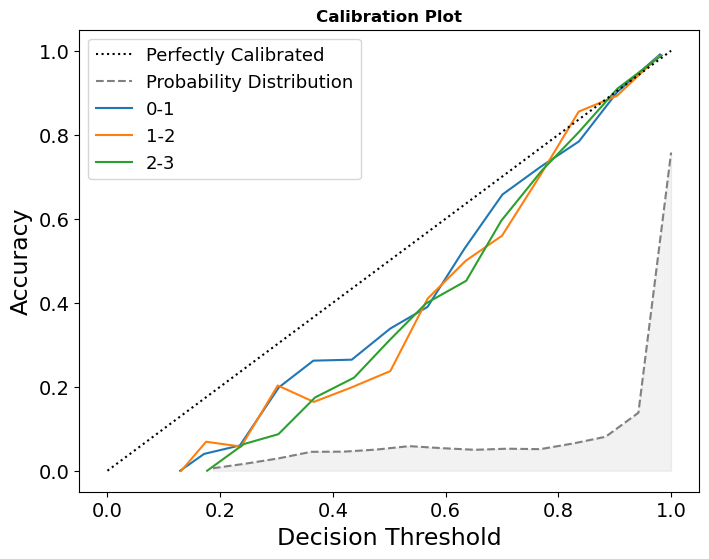

In [17]:
plot_calibration("large_mvt_6000", calibration_model=None)

0-1 0.1284507217447357
1-2 0.12477116802750322
2-3 0.12408149548775248
Total brier score: 0.1257677950866638


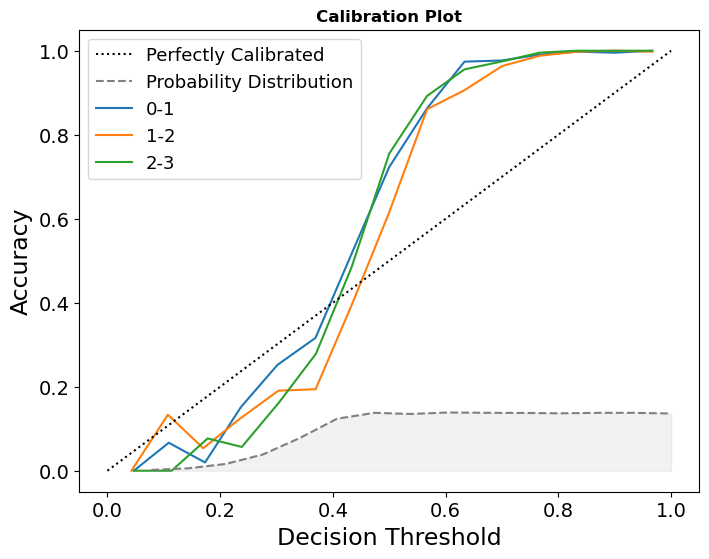

In [29]:
#ranks
plot_calibration("large_mvt_6000", calibration_model=None)

0-1 0.08825468700441948
1-2 0.08932276331100322
2-3 0.07938760003403131
Total brier score: 0.08565501678315134


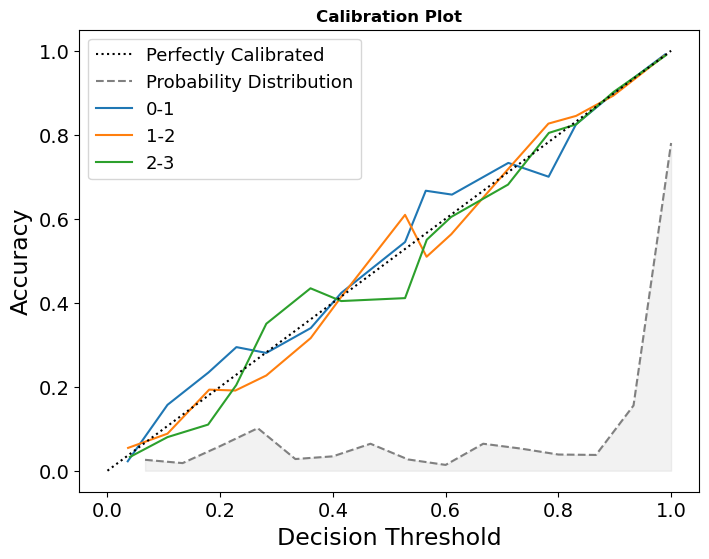

In [28]:
calibration_model = get_calibration_model("large_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.08844629449266979
1-2 0.09096474175623244
2-3 0.07977876488993521
Total brier score: 0.08639660037961247


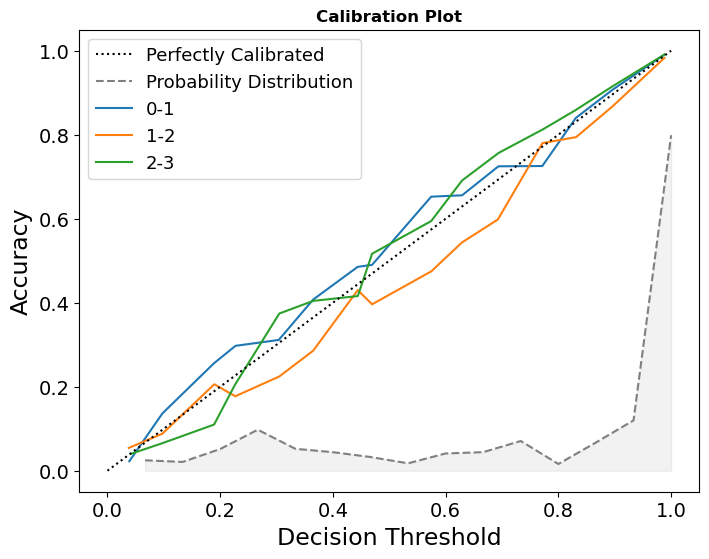

In [30]:
#ranks
calibration_model = get_calibration_model("large_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.09062212837604067
1-2 0.09537565960774352
2-3 0.08418791908858154
Total brier score: 0.09006190235745526


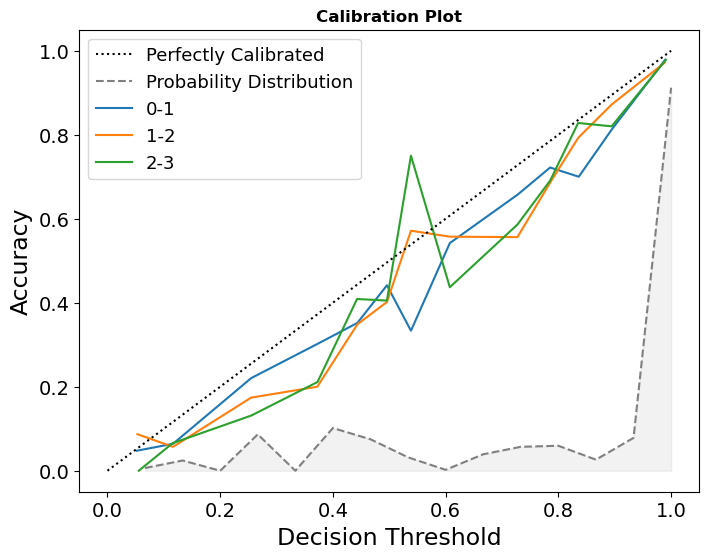

In [19]:
calibration_model = get_calibration_model("medium_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.20824897856719424
1-2 0.24306831262499257
2-3 0.21121484290022954
Total brier score: 0.22084404469747212


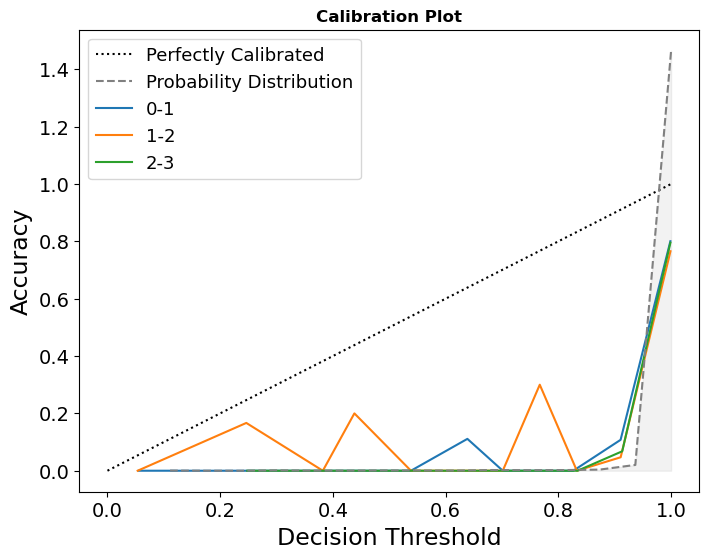

In [31]:
#ranks
calibration_model = get_calibration_model("medium_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.09257124415837963
1-2 0.09969300521021646
2-3 0.0878199223247354
Total brier score: 0.09336139056444383


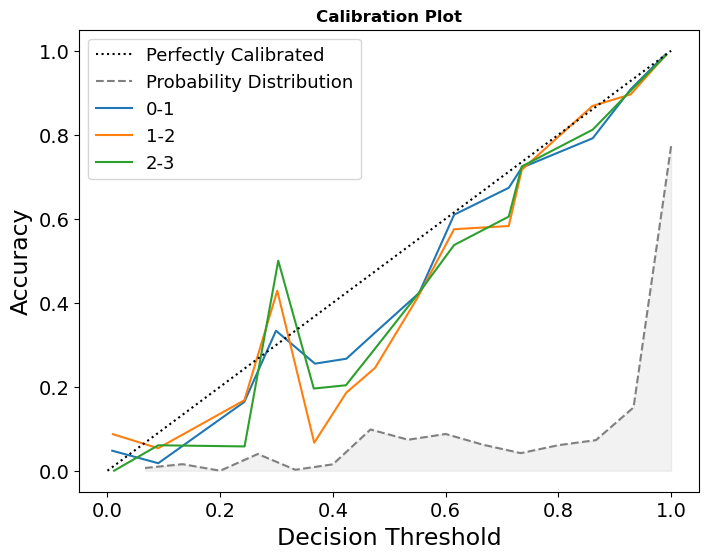

In [27]:
calibration_model = get_calibration_model("small_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.21550929966126758
1-2 0.25044595715203355
2-3 0.21657440954941004
Total brier score: 0.2275098887875704


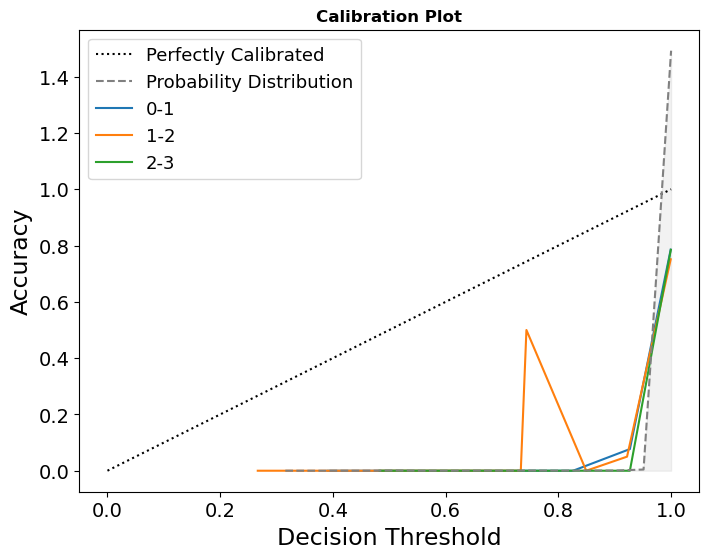

In [32]:
#ranks
calibration_model = get_calibration_model("small_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.015797195230396122
1-2 0.025177355901374293
2-3 0.017725303759094587
Total brier score: 0.019566618296954996


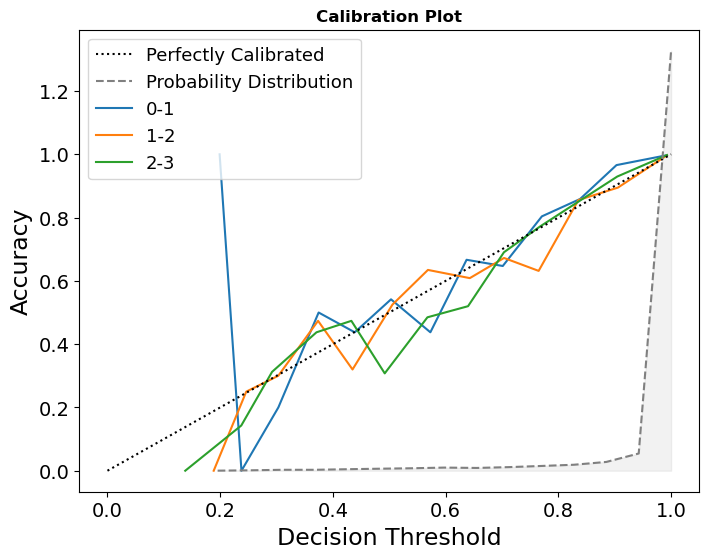

In [21]:
plot_calibration("small_mvt_6000", calibration_model=None)

0-1 0.2988609535165723
1-2 0.2765941734033953
2-3 0.2861906313662086
Total brier score: 0.2872152527620587


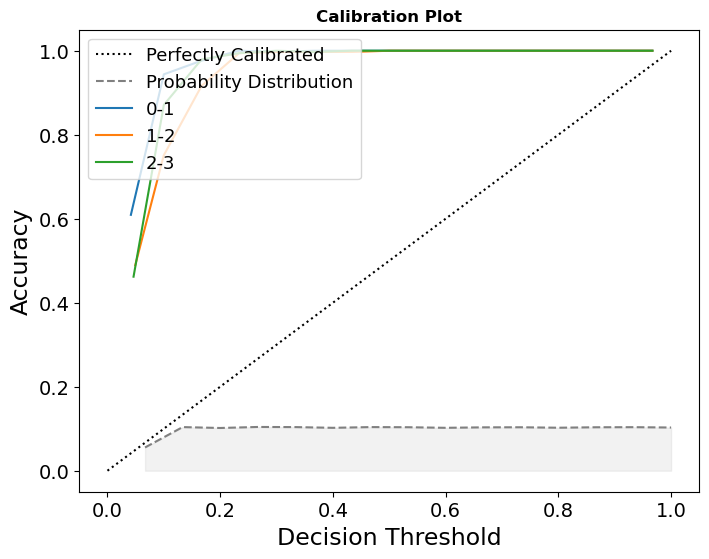

In [33]:
#ranks
plot_calibration("small_mvt_6000", calibration_model=None)

0-1 0.023332034750013417
1-2 0.03170855101983801
2-3 0.027666946213410565
Total brier score: 0.027569177327753998


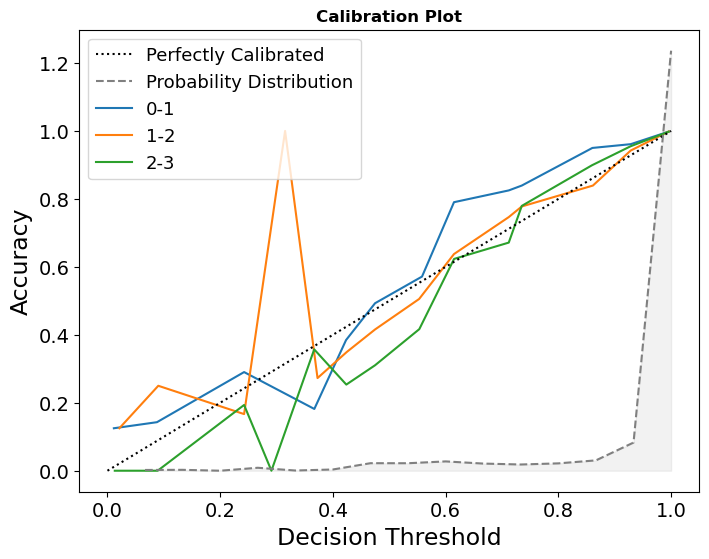

In [ ]:
calibration_model = get_calibration_model("small_mvt_6000")
plot_calibration("medium_mvt_6000", calibration_model=calibration_model)

0-1 0.028535746449341714
1-2 0.053000820926470384
2-3 0.04250386499648222
Total brier score: 0.041346810790764764


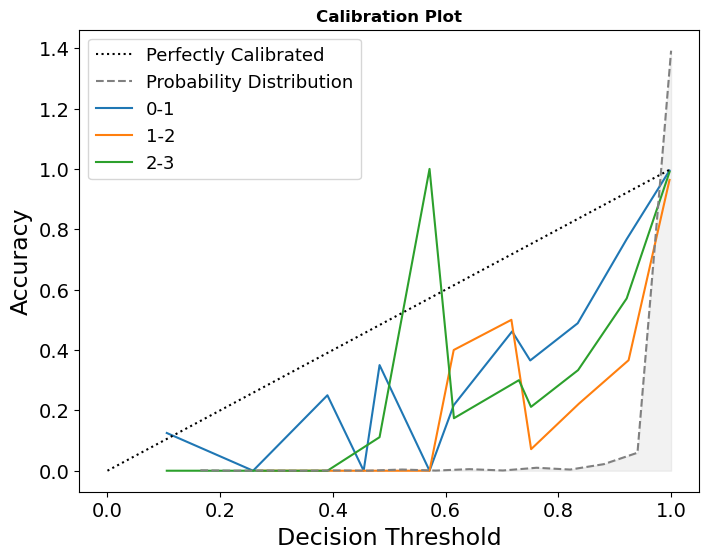

In [35]:
#ranks
calibration_model = get_calibration_model("small_mvt_6000")
plot_calibration("medium_mvt_6000", calibration_model=calibration_model)